<table align="left">
  <td>
    <a href="https://tinyurl.com/2qvvet2y" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Redes Neuronales - Clasificación con TensorFlow

Un problema de clasificación es un problema de aprendizaje supervisado en cual se busca predecir si un ejemplo pertenece a una clase o a otra.

Tipos de problemas de clasificación:

* **Clasificación binaria**: Dos clases
* **Clasificación multiclase**: Más de dos clases
* **Clasificación multietiqueta**: Cada ejemplo puede pertenecer a más de una clase

Ejemplos de problemas de clasificación son:

- Dado un correo electrónico, predecir si es spam o no.
- Dado un tumor, predecir si es maligno o benigno.
- Decidir si una imagen contiene comida, un gato o un perro.
- Dado un tweet, predecir si es positivo o negativo.
- Predecir que categoría se le debe asignar a un artículo de Wikipedia.

En este notebook se abordarán los siguientes temas:

- Arquitectura de un modelo de clasificación con TensorFlow.
- Shapes de entrada y salida.
    - X: matriz de características.
    - Y: matriz de etiquetas.
        - A que clase pertenece cada ejemplo.
- Crear datos personalizados para observar y entender el funcionamiento de un modelo de clasificación.
- Pasos para crear un modelo para clasificación binaria y multiclase.
    - Crear un modelo
    - Compilar el modelo
        - Definir la función de pérdida
        - Definir el optimizador
          - Encontrar la mejor tasa de aprendizaje
        - Definir las métricas
    - Entrenar el modelo
    - mejorar el modelo
- El poder de la no linealidad
- Evaluación de modelos de clasificación
    - Visualización del modelo
    - Observar curvas de entrenamiento y validación
    - Comparar predicciones con etiquetas reales 

## Arquitectura de un modelo de clasificación con TensorFlow


<a href="https://ibb.co/c8Rxz4Y"><img src="https://i.ibb.co/mydSQfN/imagen-2022-12-05-101854167.png" alt="nn_class" border="0"></a>
<a href=""><img src="https://tinyurl.com/2h2em9u8" alt="nn_class" border="0"></a>

## Creando Datos para observar y entrenar un modelo de clasificación

In [1]:
import tensorflow as tf
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import numpy as np
# Make 1000 examples
n_samples = 1000

# Create circles

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

# Check out the data
X[:5], y[:5]


(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [2]:
import pandas as pd

circles = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "label": y})
circles.head()

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [3]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

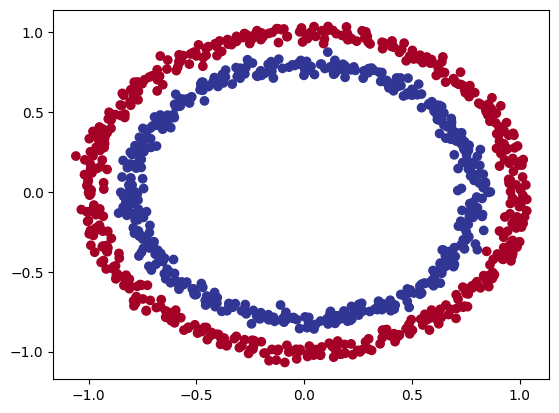

In [4]:
# View the data
# X0 = feature 0, X1 = feature 1, label = target
# 0 = blue, 1 = red
# X[:, 0] = all rows, first column
# X[:, 1] = all rows, second column

plt.scatter(x = X[:, 0], y= X[:, 1], c=y, cmap=plt.cm.RdYlBu);

## Shapes de entrada y salida

In [5]:
# check out the shapes of X and y
X.shape, y.shape

((1000, 2), (1000,))

## Crear un modelo de clasificación

In [6]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [7]:
# Set random seed
tf.random.set_seed(42)

# 1. Crear un modelo usando la API secuencial

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=(X[0].shape)),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# 2. Compilar el modelo

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 3. Ajustar el modelo
history = model.fit(X_train, y_train, epochs=100, verbose=0)

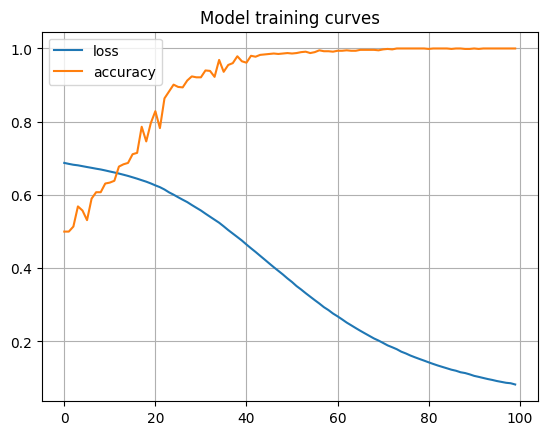

In [8]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.title("Model training curves");


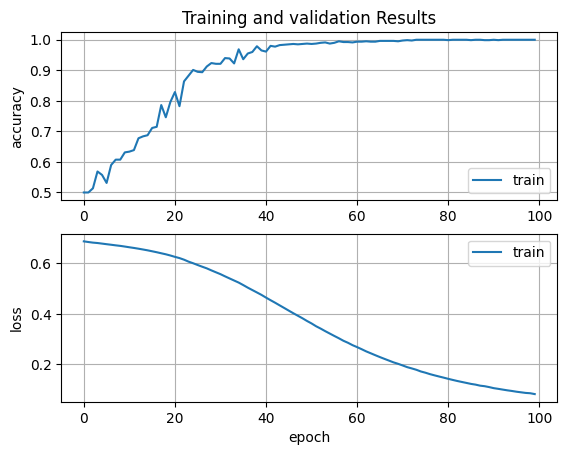

In [9]:
plt.subplot(211)
plt.title('Training and validation Results')
plt.plot(history.history['accuracy'])  
plt.ylabel('accuracy')  
plt.legend(['train'], loc='lower right')
plt.grid(True)

 # summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train'], loc='upper right')  
plt.grid(True)

plt.show()  


In [10]:
scores_train = model.evaluate(X_train, y_train, verbose=0)
scores_test = model.evaluate(X_test, y_test, verbose=0)

In [11]:
print('train loss:', round(scores_train[0]*100,2), '%')
print('test loss:', round(scores_test[0]*100,2), '%')

print('train accuracy:', round(scores_train[1]*100,2), '%')
print('test accuracy:', round(scores_test[1]*100,2), '%')

train loss: 8.05 %
test loss: 11.52 %
train accuracy: 100.0 %
test accuracy: 100.0 %


Para visualizar las predicciones del modelo, se creará una función que grafique el limite de decisión de cada clase. `plot_decision_boundary()`.
Esta función realizará lo siguiente:

- La función toma como argumentos:
    - `model`: el modelo que se desea evaluar.
    - `X`: matriz de características.
    - `y`: matriz de etiquetas.
- Crea un grid de puntos entre los valores mínimo y máximo de cada característica.
- Crea una predicción para cada punto del grid.
- Grafica los puntos del grid y colorea según la clase a la que pertenece cada punto.

In [12]:
# plot decision boundary
def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
  
  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class 
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)
  
  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

doing binary classifcation...


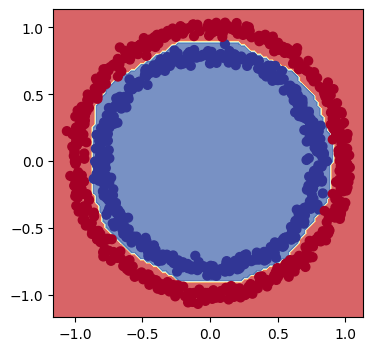

In [13]:
plt.figure(figsize=(4, 4))
plot_decision_boundary(model=model, X=X, y=y)

doing binary classifcation...
doing binary classifcation...


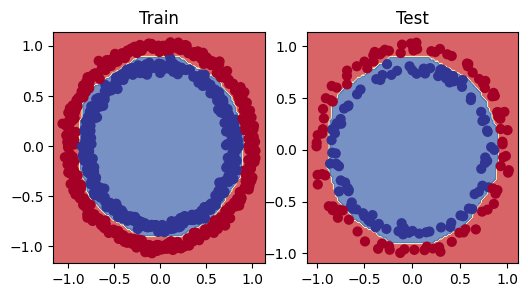

In [14]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X=X_test, y=y_test)
plt.show()

## Encontrar la mejor tasa de aprendizaje

La tasa de aprendizaje es un hiperparámetro que controla la velocidad a la que el modelo aprende. 

* se utilizan **callback** para encontrar la mejor tasa de aprendizaje. Los callbacks son funciones que se ejecutan durante el entrenamiento del modelo.

* se utiliza la función `tf.keras.callbacks.LearningRateScheduler()`

* En la función `lr_scheduler`, se define un valor inicial de 1e-4 y se multiplica por 10 cada 20 épocas para que el valor de la tasa de aprendizaje aumente.


In [25]:
# Creando función callback
# En la función `lr_scheduler`, se define un valor inicial de 1e-4 y se multiplica por 10 cada 20 épocas 
# para que el valor de la tasa de aprendizaje aumente.
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

In [27]:
# Set random seed
tf.random.set_seed(42)

# 1. Crear un modelo usando la API secuencial

model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation="relu", input_shape=(X[0].shape)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# 2. Compilar el modelo

model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer= "Adam",
                metrics=["accuracy"])

# 3. Ajustar el modelo
history = model_2.fit(X_train, y_train, epochs=100, callbacks=[lr_scheduler], verbose=0)

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'lr'])

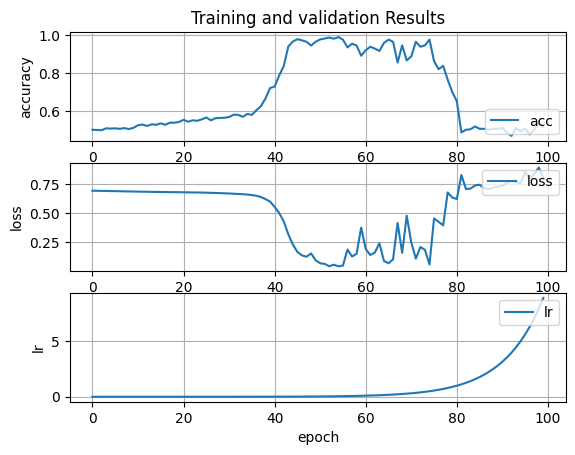

In [39]:
plt.subplot(311)
plt.title('Training and validation Results')
plt.plot(history.history['accuracy'])  
plt.ylabel('accuracy')  
plt.legend(['acc'], loc='lower right')
plt.grid(True)

 # summarize history for loss  
plt.subplot(312)  
plt.plot(history.history['loss'])  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['loss'], loc='upper right')  
plt.grid(True)

 # summarize history for loss  
plt.subplot(313)  
plt.plot(history.history['lr'])  
plt.ylabel('lr')  
plt.xlabel('epoch')  
plt.legend(['lr'], loc='upper right')  
plt.grid(True)

plt.show()  


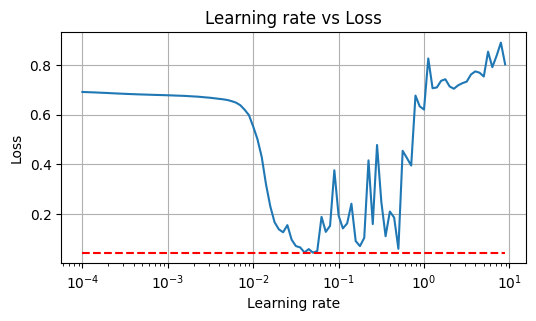

In [45]:
# Plot de la función de pérdida vs la tasa de aprendizaje

lrs = 1e-4 * (10 ** (tf.range(100) / 20))
plt.figure(figsize=(6, 3))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Learning rate vs Loss")
plt.grid(True)
plt.hlines(min(history.history["loss"]), min(lrs), max(lrs), color="r", linestyle="--")
plt.show()

> La tasa de aprendizaje ideal se puede observar en la gráfica de la función de pérdida. Cuando la función de pérdida empieza a disminuir de manera constante, se puede decir que se ha encontrado la tasa de aprendizaje ideal.

In [68]:
# Construyendo un modelo con la tasa de aprendizaje óptima

# Set random seed
tf.random.set_seed(42)

# 1. Crear un modelo usando la API secuencial

model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=(X[0].shape)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# 2. Compilar el modelo

model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer= tf.keras.optimizers.Adam(learning_rate=0.02),
                metrics=["accuracy"])

# 3. Ajustar el modelo
history = model_3.fit(X_train, y_train, epochs=20, verbose=0)

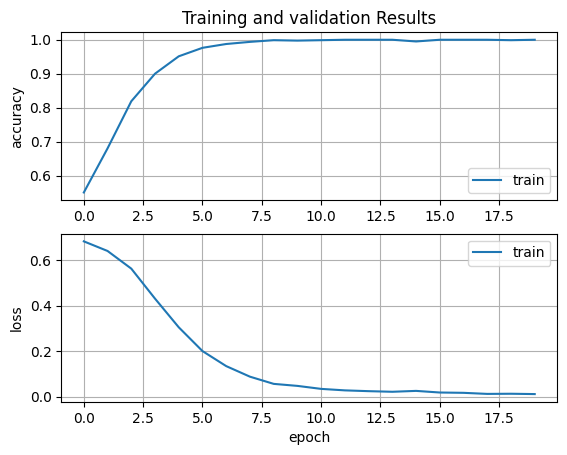

In [69]:
plt.subplot(211)
plt.title('Training and validation Results')
plt.plot(history.history['accuracy'])  
plt.ylabel('accuracy')  
plt.legend(['train'], loc='lower right')
plt.grid(True)

 # summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train'], loc='upper right')  
plt.grid(True)

plt.show()  


In [70]:
scores_train = model_3.evaluate(X_train, y_train, verbose=0)
scores_test = model_3.evaluate(X_test, y_test, verbose=0)

In [71]:
print('train loss:', round(scores_train[0]*100,2), '%')
print('test loss:', round(scores_test[0]*100,2), '%')

print('train accuracy:', round(scores_train[1]*100,2), '%')
print('test accuracy:', round(scores_test[1]*100,2), '%')

train loss: 1.57 %
test loss: 2.85 %
train accuracy: 99.75 %
test accuracy: 99.5 %


doing binary classifcation...
doing binary classifcation...


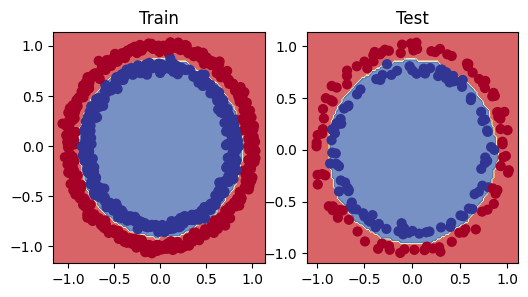

In [72]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X=X_test, y=y_test)
plt.show()

## Metricas de evaluación

* **Accuracy**: Es la cantidad de predicciones correctas que se obtienen sobre el total de predicciones. Es una métrica que no es muy útil cuando las clases están desbalanceadas. Por ejemplo, si tenemos un problema de clasificación binaria con 90% de ejemplos de una clase y 10% de ejemplos de la otra clase, un modelo que prediga siempre la clase mayoritaria tendrá una accuracy de 90%.

![acc](https://miro.medium.com/max/720/1*v2zHtE2GFJlmkQkIAqVHaQ.webp)

* **Precision**: Es la cantidad de predicciones correctas de una clase sobre el total de predicciones de esa clase. Por ejemplo, si tenemos un problema de clasificación binaria con 90% de ejemplos de una clase y 10% de ejemplos de la otra clase, un modelo que prediga siempre la clase mayoritaria tendrá una precision de 100% para la clase mayoritaria y 0% para la clase minoritaria.

![precision](https://miro.medium.com/max/720/1*HShOAF_dTFTgoqRSRCwh3A.webp)


* **Recall**: Es la cantidad de predicciones correctas de una clase sobre el total de ejemplos de esa clase. Por ejemplo, si tenemos un problema de clasificación binaria con 90% de ejemplos de una clase y 10% de ejemplos de la otra clase, un modelo que prediga siempre la clase mayoritaria tendrá una recall de 90% para la clase mayoritaria y 0% para la clase minoritaria.

![recall](https://miro.medium.com/max/720/1*HShOAF_dTFTgoqRSRCwh3A.webp)


* **F1-score**: Es la media armónica entre la precision y el recall. Por ejemplo, si tenemos un problema de clasificación binaria con 90% de ejemplos de una clase y 10% de ejemplos de la otra clase, un modelo que prediga siempre la clase mayoritaria tendrá una F1-score de 90% para la clase mayoritaria y 0% para la clase minoritaria.

![f1](https://miro.medium.com/max/720/1*z16cum9tV33osJAvdHttBg.webp)


* **Confusion Matrix**: Es una matriz que muestra la cantidad de predicciones correctas e incorrectas de cada clase. La matriz de confusión es una matriz cuadrada que tiene como dimensiones el número de clases. En la diagonal principal se encuentran los valores de las predicciones correctas y en el resto de las celdas se encuentran los valores de las predicciones incorrectas.

![Confusion Matrix](https://miro.medium.com/max/720/1*tL4NzKYMSxaByuu_k-B_Iw.webp)

[Referencia: Performance metrics for binary classifier](https://towardsdatascience.com/performance-metrics-for-binary-classifier-in-simple-words-be958535db49)